# Processing RNO-G data

This notebook will show how to read and process RNO-G data

We will follow the accepted workflow and make use of the readRNOGData class to read in and loop over the RNOG data. This class uses mattak datasets in the backend, hence mattak is a prerequisite for making use of this class.\
You can install mattak in your venv via pip using " pip install git+https://github.com/RNO-G/mattak.git "

In [12]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import os

from NuRadioReco.modules.io.RNO_G.readRNOGDataMattak import readRNOGData
from NuRadioReco.utilities import units

The reader makes use of the rnog-runtable (https://github.com/RNO-G/rnog-runtable) to filter runs. If not already installed the reader will give you a convenient warning with the instructions to install the runtable using  a pip install.

In [13]:
rnog_reader = readRNOGData()

To start reading in data the reader has a begin function that expects a list (or single instance) of run directories (e.g. /path/to/data/station11/run1016) or a list of root directories (e.g. /path/to/data/station11/run1016/combined.root) if a combined.root object is available.The recomendation is to alway pass run directories. We assume the root rnog data directory is stored in the "RNO_G_DATA" environmental variable on your machine

In [14]:
run_directory = os.environ["RNO_G_DATA"] + "/" + "station11" + "/" + "run1016"

#### Filter run options
The reader also allows you to set constraints on what data you want to read. You can set what run_types to select ("physics", "debug", "calibration", "broken") or set a limit on the maximum trigger rates.

In [15]:
run_types = ["physics"]
max_trigger_rate = 2 * units.Hz

If you want to set further constraints that do not appear as an option in the begin function you can pass a list of functions as selectors. These functions should accept the event_info and return a boolean based on what you want to constrain. The attributes of eventinfo are include below:
<ul>
<li> eventNumber: int </li> 
<li> station : int  </li>
<li> run: int  </li>
<li> readoutTime : float  </li>
<li> triggerTime : float  </li>
<li> triggerType: str  </li>
<li> sysclk: int  </li>
<li> sysclkLastPPS: Tuple[int, int]  # the last 2 PPS sysclks, most recent first  </li>
<li> pps: int  </li>
<li> radiantStartWindows: numpy.ndarray  </li>
<li> sampleRate: Optional[float]  # Sample rate, in GSa/s  </li>
<li> radiantThrs: Optional[numpy.ndarray]  </li>
<li> lowTrigThrs: Optional[numpy.ndarray]  </li>
<li> hasWaveforms: bool = True  </li>
<li> readoutDelay: Optional[numpy.ndarray] = None  # Default value is 0 (set in the backends)  </li>
</ul>

As an example we will only select forced triggers

In [16]:
selectors = [lambda event_info : event_info.triggerType == "FORCE"]

#### Mattak backend options
The final option we will discuss are the options you can pass to the mattak backend of the reader. The most important of which is what backend to use for reading the .ROOT files. "uproot" is a purely pythonic backend hence this backend acts slower but does not require a working ROOT installation. "pyroot" is a faster C++ backend and requires a working ROOT installation. The mattak pip install only installs pyroot if a working ROOT installation is detected on your system. For simplicity we will assume ROOT was not installed.

In [17]:
mattak_kwargs = {
    "backend" : "uproot",
    # "backend" : "pyroot"
    }

Note that we choose all these options already knowing that run1016 satisfies these conditions

In [18]:
rnog_reader.begin(run_directory,
                  run_types=run_types,
                  selectors=selectors,
                  max_trigger_rate=max_trigger_rate,
                  mattak_kwargs=mattak_kwargs)

ERROR:root:Could not find any calibration files


The reader contains a "run" function to loop over the events included in the passed run directories.

In [30]:
for event in rnog_reader.run():
    event_id = event.get_id()
    print(f"Showing even id {event_id}")
    station = event.get_station()
    print("Event contains channels: ", end = '')
    for channel in station.iter_channels():
        print(channel.get_id(), end=' ')
    break

Showing even id 4
Event contains channels: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 

For example, we can plot the trace of channel 0 in the first event

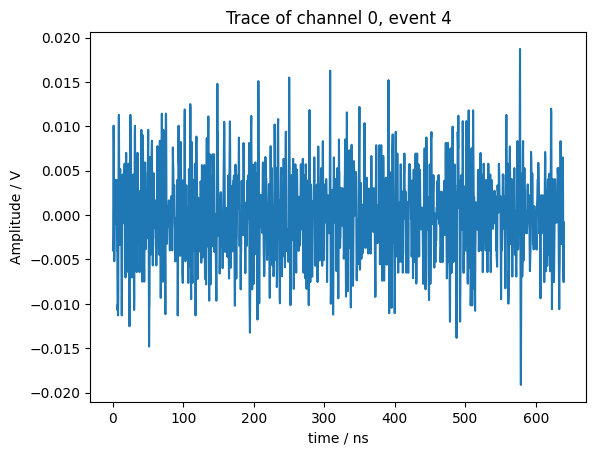

In [33]:
channel_id = 0

for event in rnog_reader.run():
    event_id = event.get_id()
    station = event.get_station()
    channel = station.get_channel(channel_id)
    times = channel.get_times()
    trace = channel.get_trace()
    plt.plot(times, trace)
    plt.xlabel("time / ns")
    plt.ylabel("Amplitude / V")
    plt.title(f"Trace of channel {channel_id}, event {event_id}")
    break

### The RNO-G detector object

Before continuing we should first explain the RNO-G "Detector" class. This class contains all the information pertaining to the RNO-G detector such as cable delays and system responses. We need to define this object here before continuing since some NuRadio functionalities require a detector object in what follows.\
The detector gathers all it's information either from a json file (outdated) or by querying the information from a mongodb database. To ensure the detector uses this database we specify the information source using the "source" argument.

In [ ]:
from NuRadioReco.detector.detector import Detector
det = Detector(source="rnog_mongo")

The detector class is quite versatile in that it is able to query the detector information at any given date. To choose a date we can use the "update" function. this function accepts either an astropy Time object or a datetime object.

In [45]:
from astropy.time import Time
det.update(Time("2022-08-01"))

### NuRadio modules

NuRadio contains many modules which can be used to apply functions / filters or other changes to the events in the reader. All of these modules are coded to the same structure as the reader. Hence they have a begin function for their overhanging settings and a run function to be applied to an event. To illustrate this we will apply an <b>essential</b> module in NuRadio, titled channelAddCableDelay to remove the cable delays in the data.

For more info see : https://nu-radio.github.io/NuRadioMC/NuRadioReco/pages/nur_modules.html

In [46]:
from NuRadioReco.modules.channelAddCableDelay import channelAddCableDelay
channelCableDelayAdder = channelAddCableDelay()
channelCableDelayAdder.begin()

All NuRadio modules are designed to execute their run function in a reader's run function. They all accept their arguments as (event, station, detector, module_specific_options). Not all modules make use of all three of these but they are still accepted to equalize all run functions. Make sure to check the NuRadio docs/source code to know which arguments matter. We will now apply the cable delay removal to our workflow.

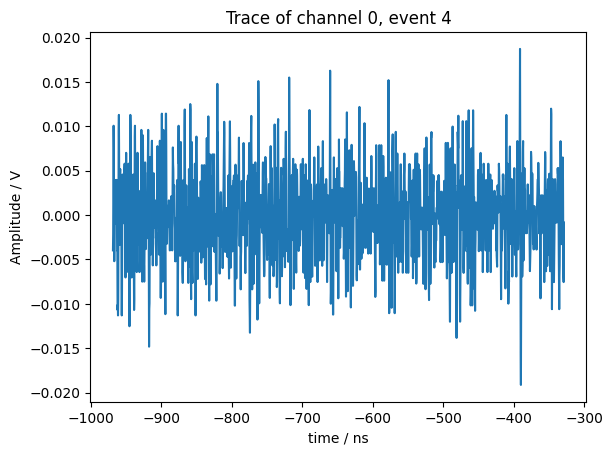

In [49]:
channel_id = 0

for event in rnog_reader.run():
    event_id = event.get_id()
    station = event.get_station()

    det.update(station.get_station_time())
    channelCableDelayAdder.run(event, station, det, mode="subtract")

    channel = station.get_channel(channel_id)
    times = channel.get_times()
    trace = channel.get_trace()
    plt.plot(times, trace)
    plt.xlabel("time / ns")
    plt.ylabel("Amplitude / V")
    plt.title(f"Trace of channel {channel_id}, event {event_id}")
    break

Not here that we can apply the detector update function as many times as we want. The detector will not reload it's information if the given data contains the same info as the previously set date. \
<b> It is hence good practice to always call "det.update(station.get_station_time())" in the reader run loop </b>

As a final example we will demonstrate how to apply a bandpassfilter on given data.

In [50]:
from NuRadioReco.modules.channelBandPassFilter import channelBandPassFilter

channelFilterBand = channelBandPassFilter()
channelFilterBand.begin()

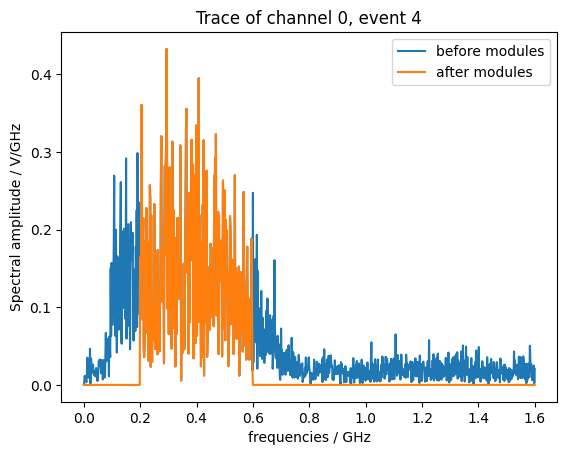

In [68]:
channel_id = 0
passband = [200 * units.MHz, 600 * units.MHz]

for event in rnog_reader.run():
    event_id = event.get_id()
    station = event.get_station()

    channel = station.get_channel(channel_id)
    frequencies = channel.get_frequencies()
    frequency_spectrum_before_modules = channel.get_frequency_spectrum()

    det.update(station.get_station_time())
    channelCableDelayAdder.run(event, station, det, mode="subtract")
    channelFilterBand.run(event, station, det, passband, filter_type="rectangular")

    channel = station.get_channel(channel_id)
    frequency_spectrum_after_modules = channel.get_frequency_spectrum()
    plt.plot(frequencies, np.abs(frequency_spectrum_before_modules), label = "before modules")
    plt.plot(frequencies, np.abs(frequency_spectrum_after_modules), label = "after modules")
    plt.xlabel("frequencies / GHz")
    plt.ylabel("Spectral amplitude / V/GHz")
    plt.legend()
    plt.title(f"Trace of channel {channel_id}, event {event_id}")
    break

### Conclusion

Now you can loop over RNO-G events using the readRNOGData class. You learned how to apply NuRadio's modules in the reader loop and how to extract data from events in the form of traces and frequency spectra. To start an analyses, load in the appropriate data files, set your selectors and apply your chosen modules in the reader run function.